# Convolutional Neural Network

I modified the code that is brought from the following reference: https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/401_CNN.py

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_class = 10
n_epoch = 5
batch_size = 256
test_batch_size = 1000
lr = 1e-3
device = 0

In [3]:
train_data = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)

In [4]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

    def classify(self, img):
        logit, x = self(img)
        return self.classify_from_logit(logit), x

    def classify_from_logit(self, logit):
        return logit.argmax(dim=-1)

In [6]:
classifier = CNN().to(device)
print(classifier)  # net architecture

optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()                       

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [7]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

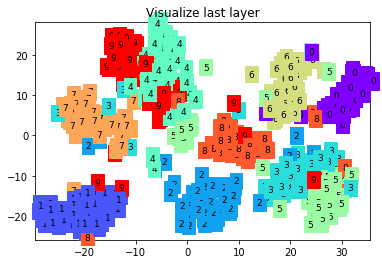

Train-Acc@0: 0.90175
Test-Acc@0: 0.9698


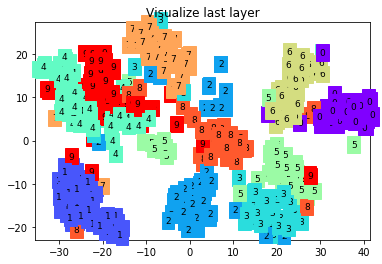

Train-Acc@1: 0.9734666666666667
Test-Acc@1: 0.9818


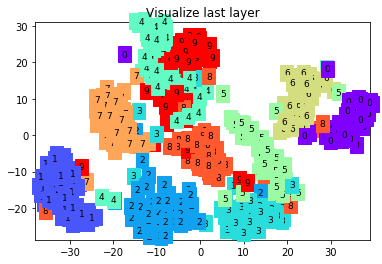

Train-Acc@2: 0.9803333333333333
Test-Acc@2: 0.982


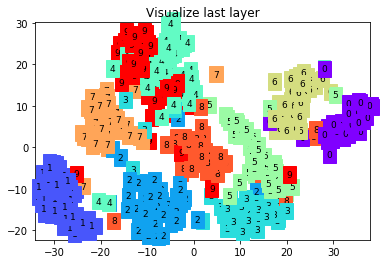

Train-Acc@3: 0.98485
Test-Acc@3: 0.9863


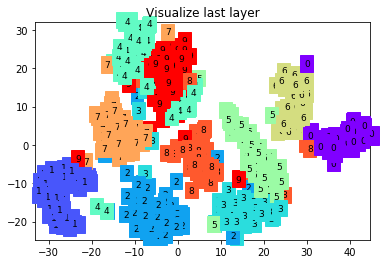

Train-Acc@4: 0.98705
Test-Acc@4: 0.9879


In [8]:
train_accs = []
test_accs = []

for epoch_i in range(n_epoch):
    correct = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        logit, _ = classifier(x)
        loss = loss_func(logit, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = classifier.classify_from_logit(logit)
        correct += (y_pred == y).sum().item()

    train_accs.append(correct / len(train_data))

    with torch.no_grad():
        correct = 0

        for _index, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)

            y_pred, last_layer = classifier.classify(x)
            correct += (y_pred == y).sum().item()

            if HAS_SK and _index == 0:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.cpu().data.numpy()[:plot_only, :])
                labels = y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)

        test_accs.append(correct / len(test_data))
        
    print("Train-Acc@{}: {}".format(epoch_i, train_accs[-1]))
    print("Test-Acc@{}: {}".format(epoch_i, test_accs[-1]))

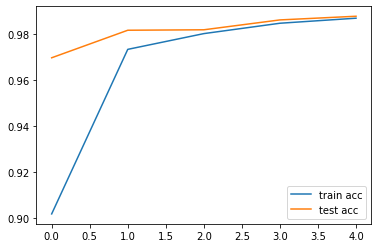

In [9]:
plt.plot(train_accs, label='train acc')
plt.plot(test_accs, label='test acc')
plt.legend()